In [1]:
import os
import json
import pandas as pd
from pathlib import Path
from PIL import Image
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Betöltés

In [2]:
annotation_path_1 = "../mouth/train/_annotations.coco.json"
data_dir_1 = "../mouth/train"

with open(annotation_path_1) as f:
    coco1 = json.load(f)

images1 = {img["id"]: img["file_name"] for img in coco1["images"]}
categories1 = {cat["id"]: cat["name"].lower() for cat in coco1["categories"]}

records = []

for ann in coco1["annotations"]:
    image_id = ann["image_id"]
    label_name = categories1[ann["category_id"]]
    file_name = images1[image_id]
    bbox = ann["bbox"]
    records.append({"filepath": os.path.join(data_dir_1, file_name), "label": label_name, "bbox": bbox})

# Bővítés
annotation_path_2 = "../mouth/Open-Close Mouth.v1i.coco-mmdetection/train/_annotations.coco.json"
data_dir_2 = "../mouth/Open-Close Mouth.v1i.coco-mmdetection/train"

with open(annotation_path_2) as f:
    coco2 = json.load(f)

images2 = {img["id"]: img["file_name"] for img in coco2["images"]}
categories2 = {cat["id"]: cat["name"].lower() for cat in coco2["categories"]}

for ann in coco2["annotations"]:
    image_id = ann["image_id"]
    label_name = categories2[ann["category_id"]]
    if label_name == "open":
        file_name = images2[image_id]
        bbox = ann["bbox"]
        records.append({"filepath": os.path.join(data_dir_2, file_name), "label": "yawn", "bbox": bbox})



full_df = pd.DataFrame(records)
print("Összes kép száma:", len(full_df))
print(full_df['label'].value_counts())

Összes kép száma: 10276
label
normal    4605
talk      3615
yawn      2056
Name: count, dtype: int64


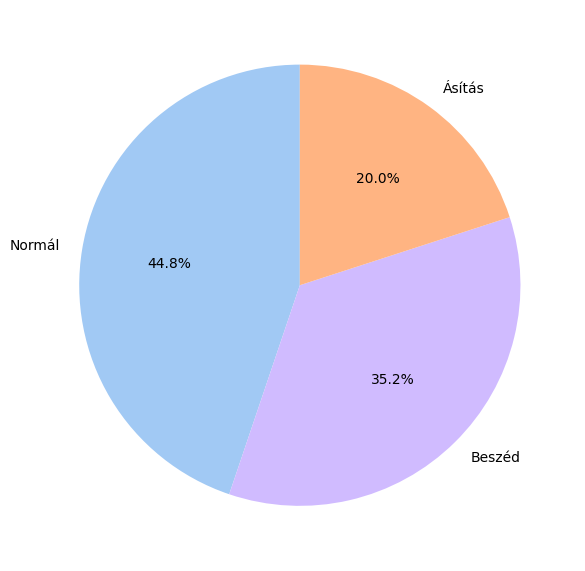

In [3]:
lab = full_df["label"].value_counts()
labels = lab.index.map({"normal": "Normál", "talk": "Beszéd", "yawn": "Ásítás"})
colors = ["#A1C9F4", "#D0BBFF", "#FFB482"]

plt.figure(figsize=(6,6))
plt.pie(lab, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
plt.tight_layout()
plt.show()

Előkészítés

In [4]:
class MouthDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.label_map = {"normal": 0, "talk": 1, "yawn": 2}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row["filepath"]).convert("RGB")
        bbox = row["bbox"]

        x, y, w, h = bbox
        x, y, w, h = int(x), int(y), int(w), int(h)
        img = img.crop((x, y, x + w, y + h))

        if self.transform:
            img = self.transform(img)

        label = self.label_map[row["label"]]
        return img, label

In [5]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

In [6]:
BATCH = 32
train_df, temp_df = train_test_split(full_df, test_size=0.3, stratify=full_df["label"], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["label"], random_state=42)

train_dataset = MouthDataset(train_df, transform=train_transform)
val_dataset = MouthDataset(val_df, transform=val_transform)
test_dataset = MouthDataset(test_df, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH, shuffle=False)

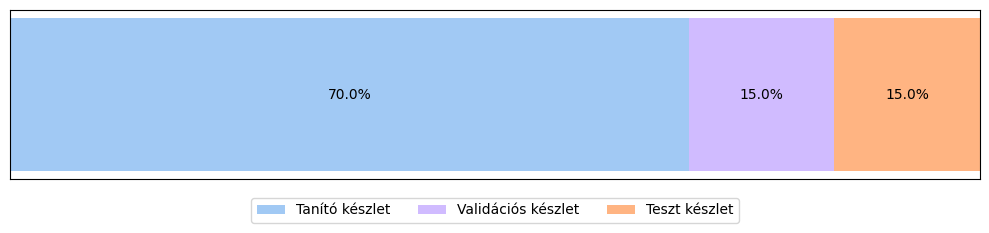

In [7]:
train_size = len(train_df)
val_size = len(val_df)
test_size = len(test_df)
total = train_size + val_size + test_size

train_ratio = train_size / total
val_ratio = val_size / total
test_ratio = test_size / total

fig, ax = plt.subplots(figsize=(10, 2.5))

ax.barh(0, train_ratio, color="#A1C9F4", label="Tanító készlet")
ax.barh(0, val_ratio, left=train_ratio, color="#D0BBFF", label="Validációs készlet")
ax.barh(0, test_ratio, left=train_ratio + val_ratio, color="#FFB482", label="Teszt készlet")

ax.text(train_ratio / 2, 0, f"{train_ratio * 100:.1f}%", ha="center", va="center", fontsize=10)
ax.text(train_ratio + val_ratio / 2, 0, f"{val_ratio * 100:.1f}%", ha="center", va="center", fontsize=10)
ax.text(train_ratio + val_ratio + test_ratio / 2, 0, f"{test_ratio * 100:.1f}%", ha="center", va="center", fontsize=10)

ax.set_yticks([])
ax.set_xticks([])
ax.set_xlim(0, 1)
#ax.set_title("Adathalmaz megoszlása", fontsize=12)
ax.legend(loc="lower center", bbox_to_anchor=(0.5, -0.3), ncol=3)
plt.tight_layout()
plt.show()

Model

In [8]:
class MouthCNN(nn.Module):
    def __init__(self):
        super(MouthCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(256 * 14 * 14, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc4 = nn.Linear(128, 3)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x

model = MouthCNN().to(device)

In [9]:
criterion = nn.CrossEntropyLoss(weight=torch.tensor([1.0, 1.5, 2.5], dtype=torch.float).to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5, verbose=True)

In [10]:
num_epochs = 20
patience = 5

best_val_loss = float('inf')
epochs_without_improvement = 0

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    train_preds, train_labels = [], []

    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = outputs.argmax(dim=1)
        train_preds.extend(preds.cpu().numpy().tolist())
        train_labels.extend(labels.cpu().numpy().tolist())

    avg_train_loss = running_loss / len(train_loader)
    train_acc = accuracy_score(train_labels, train_preds)
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    print(f"Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}")

    # Validáció
    model.eval()
    running_val_loss = 0.0
    val_preds, val_labels = [], []

    with torch.no_grad():
        for imgs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            running_val_loss += loss.item()
            preds = outputs.argmax(dim=1)
            val_preds.extend(preds.cpu().numpy().tolist())
            val_labels.extend(labels.cpu().numpy().tolist())

    avg_val_loss = running_val_loss / len(val_loader)
    val_acc = accuracy_score(val_labels, val_preds)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)

    print(f"Validation: Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}")

    scheduler.step(avg_val_loss)

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        break


Epoch 1/20 - Training: 100%|██████████| 225/225 [00:56<00:00,  3.98it/s]


Epoch 1: Train Loss: 0.9271, Train Acc: 0.5865


Epoch 1/20 - Validation: 100%|██████████| 49/49 [00:09<00:00,  5.35it/s]


Validation: Val Loss: 0.3133, Val Acc: 0.8916


Epoch 2/20 - Training: 100%|██████████| 225/225 [00:28<00:00,  7.98it/s]


Epoch 2: Train Loss: 0.4829, Train Acc: 0.8272


Epoch 2/20 - Validation: 100%|██████████| 49/49 [00:03<00:00, 15.16it/s]


Validation: Val Loss: 0.3150, Val Acc: 0.8949


Epoch 3/20 - Training: 100%|██████████| 225/225 [00:28<00:00,  7.94it/s]


Epoch 3: Train Loss: 0.4066, Train Acc: 0.8610


Epoch 3/20 - Validation: 100%|██████████| 49/49 [00:03<00:00, 15.26it/s]


Validation: Val Loss: 0.2487, Val Acc: 0.9176


Epoch 4/20 - Training: 100%|██████████| 225/225 [00:27<00:00,  8.04it/s]


Epoch 4: Train Loss: 0.3668, Train Acc: 0.8814


Epoch 4/20 - Validation: 100%|██████████| 49/49 [00:03<00:00, 15.25it/s]


Validation: Val Loss: 0.2326, Val Acc: 0.9338


Epoch 5/20 - Training: 100%|██████████| 225/225 [00:28<00:00,  7.96it/s]


Epoch 5: Train Loss: 0.3354, Train Acc: 0.8914


Epoch 5/20 - Validation: 100%|██████████| 49/49 [00:03<00:00, 15.41it/s]


Validation: Val Loss: 0.2243, Val Acc: 0.9221


Epoch 6/20 - Training: 100%|██████████| 225/225 [00:27<00:00,  8.04it/s]


Epoch 6: Train Loss: 0.3358, Train Acc: 0.8893


Epoch 6/20 - Validation: 100%|██████████| 49/49 [00:03<00:00, 15.21it/s]


Validation: Val Loss: 0.2134, Val Acc: 0.9221


Epoch 7/20 - Training: 100%|██████████| 225/225 [00:27<00:00,  8.07it/s]


Epoch 7: Train Loss: 0.3083, Train Acc: 0.8930


Epoch 7/20 - Validation: 100%|██████████| 49/49 [00:03<00:00, 15.38it/s]


Validation: Val Loss: 0.2457, Val Acc: 0.9117


Epoch 8/20 - Training: 100%|██████████| 225/225 [00:27<00:00,  8.04it/s]


Epoch 8: Train Loss: 0.3083, Train Acc: 0.9050


Epoch 8/20 - Validation: 100%|██████████| 49/49 [00:03<00:00, 15.26it/s]


Validation: Val Loss: 0.1963, Val Acc: 0.9260


Epoch 9/20 - Training: 100%|██████████| 225/225 [00:28<00:00,  7.99it/s]


Epoch 9: Train Loss: 0.2855, Train Acc: 0.9042


Epoch 9/20 - Validation: 100%|██████████| 49/49 [00:03<00:00, 14.97it/s]


Validation: Val Loss: 0.1944, Val Acc: 0.9409


Epoch 10/20 - Training: 100%|██████████| 225/225 [00:28<00:00,  8.01it/s]


Epoch 10: Train Loss: 0.2856, Train Acc: 0.9082


Epoch 10/20 - Validation: 100%|██████████| 49/49 [00:03<00:00, 15.10it/s]


Validation: Val Loss: 0.2018, Val Acc: 0.9286


Epoch 11/20 - Training: 100%|██████████| 225/225 [00:28<00:00,  7.95it/s]


Epoch 11: Train Loss: 0.2898, Train Acc: 0.9075


Epoch 11/20 - Validation: 100%|██████████| 49/49 [00:03<00:00, 15.13it/s]


Validation: Val Loss: 0.2313, Val Acc: 0.9332


Epoch 12/20 - Training: 100%|██████████| 225/225 [00:28<00:00,  7.99it/s]


Epoch 12: Train Loss: 0.2726, Train Acc: 0.9124


Epoch 12/20 - Validation: 100%|██████████| 49/49 [00:03<00:00, 15.07it/s]


Validation: Val Loss: 0.2075, Val Acc: 0.9384


Epoch 13/20 - Training: 100%|██████████| 225/225 [00:28<00:00,  7.89it/s]


Epoch 13: Train Loss: 0.2529, Train Acc: 0.9234


Epoch 13/20 - Validation: 100%|██████████| 49/49 [00:03<00:00, 15.25it/s]


Validation: Val Loss: 0.1745, Val Acc: 0.9403


Epoch 14/20 - Training: 100%|██████████| 225/225 [00:28<00:00,  8.01it/s]


Epoch 14: Train Loss: 0.2316, Train Acc: 0.9231


Epoch 14/20 - Validation: 100%|██████████| 49/49 [00:03<00:00, 14.98it/s]


Validation: Val Loss: 0.2010, Val Acc: 0.9429


Epoch 15/20 - Training: 100%|██████████| 225/225 [00:28<00:00,  7.94it/s]


Epoch 15: Train Loss: 0.2371, Train Acc: 0.9256


Epoch 15/20 - Validation: 100%|██████████| 49/49 [00:03<00:00, 15.56it/s]


Validation: Val Loss: 0.1823, Val Acc: 0.9455


Epoch 16/20 - Training: 100%|██████████| 225/225 [00:27<00:00,  8.06it/s]


Epoch 16: Train Loss: 0.2423, Train Acc: 0.9252


Epoch 16/20 - Validation: 100%|██████████| 49/49 [00:03<00:00, 15.24it/s]


Validation: Val Loss: 0.1832, Val Acc: 0.9416


Epoch 17/20 - Training: 100%|██████████| 225/225 [00:28<00:00,  8.00it/s]


Epoch 17: Train Loss: 0.2152, Train Acc: 0.9276


Epoch 17/20 - Validation: 100%|██████████| 49/49 [00:03<00:00, 15.05it/s]


Validation: Val Loss: 0.1695, Val Acc: 0.9448


Epoch 18/20 - Training: 100%|██████████| 225/225 [00:28<00:00,  8.01it/s]


Epoch 18: Train Loss: 0.2119, Train Acc: 0.9341


Epoch 18/20 - Validation: 100%|██████████| 49/49 [00:03<00:00, 15.05it/s]


Validation: Val Loss: 0.1776, Val Acc: 0.9371


Epoch 19/20 - Training: 100%|██████████| 225/225 [00:28<00:00,  8.01it/s]


Epoch 19: Train Loss: 0.2034, Train Acc: 0.9376


Epoch 19/20 - Validation: 100%|██████████| 49/49 [00:03<00:00, 15.12it/s]


Validation: Val Loss: 0.1520, Val Acc: 0.9507


Epoch 20/20 - Training: 100%|██████████| 225/225 [00:28<00:00,  8.03it/s]


Epoch 20: Train Loss: 0.2142, Train Acc: 0.9333


Epoch 20/20 - Validation: 100%|██████████| 49/49 [00:03<00:00, 15.12it/s]

Validation: Val Loss: 0.1695, Val Acc: 0.9468


In [11]:
val_precision = precision_score(val_labels, val_preds, average='weighted', zero_division=0)
val_recall = recall_score(val_labels, val_preds, average='weighted', zero_division=0)
val_f1 = f1_score(val_labels, val_preds, average='weighted', zero_division=0)

print(f"Validation Precision: {val_precision:.4f}")
print(f"Validation Recall: {val_recall:.4f}")
print(f"Validation F1-score: {val_f1:.4f}")

Validation Precision: 0.9472
Validation Recall: 0.9468
Validation F1-score: 0.9464


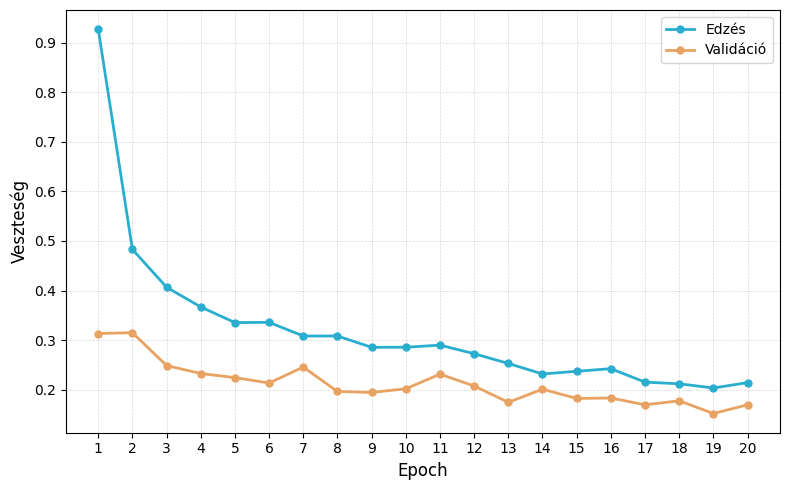

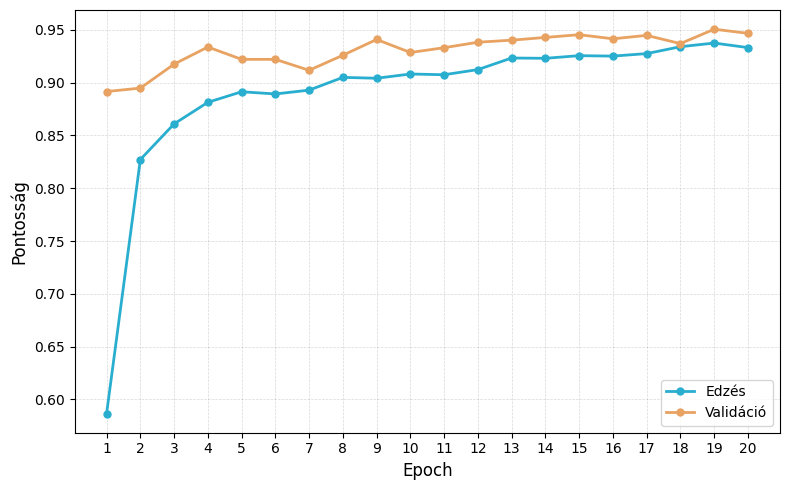

In [12]:
epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs_range, train_losses, label="Edzés", marker="o", markersize=5, linewidth=2, color='#2AAECF')
plt.plot(epochs_range, val_losses, label="Validáció", marker="o", markersize=5, linewidth=2, color='#E8A262')
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Veszteség", fontsize=12)
plt.legend(fontsize=10)
plt.xticks(ticks=epochs_range)
plt.grid(True, color='gray', alpha=0.3, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(epochs_range, train_accuracies, label="Edzés", marker="o", markersize=5, linewidth=2, color='#2AAECF')
plt.plot(epochs_range, val_accuracies, label="Validáció", marker="o", markersize=5, linewidth=2, color='#E8A262')
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Pontosság", fontsize=12)
plt.legend(fontsize=10)
plt.xticks(ticks=epochs_range)
plt.grid(True, color='gray', alpha=0.3, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

Teszt

In [13]:
model.eval()
running_test_loss = 0.0
test_preds, test_labels = [], []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        running_test_loss += loss.item()
        preds = outputs.argmax(dim=1)
        test_preds.extend(preds.cpu().numpy().tolist())
        test_labels.extend(labels.cpu().numpy().tolist())

avg_test_loss = running_test_loss / len(test_loader)
test_acc = accuracy_score(test_labels, test_preds)
test_precision = precision_score(test_labels, test_preds, average='macro', zero_division=0)
test_recall = recall_score(test_labels, test_preds, average='macro', zero_division=0)
test_f1 = f1_score(test_labels, test_preds, average='macro', zero_division=0)

print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1-score: {test_f1:.4f}")

Test Accuracy: 0.9449
Test Precision: 0.9425
Test Recall: 0.9457
Test F1-score: 0.9435


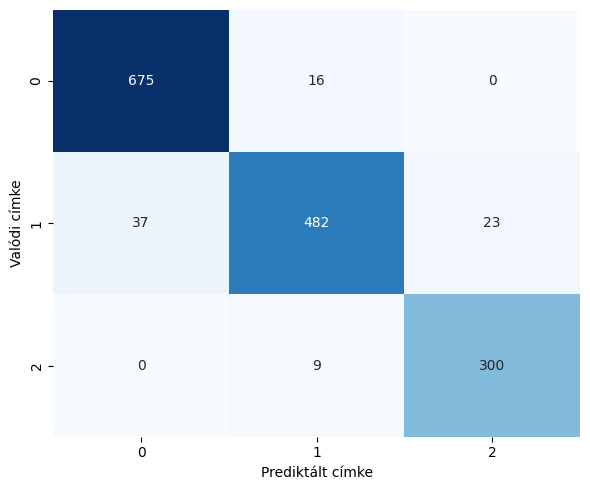

In [14]:
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Prediktált címke')
plt.ylabel('Valódi címke')
plt.tight_layout()
plt.show()


Mentés

In [15]:
#torch.save(model.state_dict(), "test2m.pth")
#print("modell mentve")